# Bach network

Date: 2025/07/13, 2025/07/26

Free book "Johann Sebastian Bach: His Life, Art, and Work" from Project Gutenberg: https://www.gutenberg.org/ebooks/35041

I started studying NLP with spaCy a year and a half ago and have been using NLP at work.
However, as the context window size of LLMs has increased, it has become possible to perform various NLP tasks while including the entire text in the prompt.

What I learned with spaCy has been very useful, but there are now more cases where I no longer need to use spaCy itself.

As everyone says, using generative AI has reduced the time spent on mechanical and tedious programming, allowing me to spend more time on advanced tasks. Advanced tasks involve deeply observing people and organizations, considering what data to prepare and how to process it in order to produce accurate results.

In [26]:
#!pip3 install google.genai
#!pip3 install networkx
#!pip3 install matplotlib
#!pip3 install scipy

In [24]:
import google.genai as genai
import os

GEMINI_API_KEY = os.environ["GEMINI_API_KEY"]
MODEL = "gemini-2.5-flash"

client = genai.Client(api_key=GEMINI_API_KEY)

In [3]:
import sqlite3

import pandas as pd
with sqlite3.connect('./data/bach.db') as conn:
    paragraphs = pd.read_sql('SELECT * FROM paragraphs', conn)
    
paragraphs.head()

,index,paragraph
0,0,If there is such a thing as inherited aptitude...
1,1,"Veit Bach, ancestor of this famous family, gai..."
2,2,"Not all the Bachs, however, were great musicia..."
3,3,We do not know whether they rewarded the expec...
4,4,"Besides these three men, the Bachs boasted sev..."


## Edges

In [6]:
from pydantic import BaseModel

class Object(BaseModel):
    value: int
    pidx: list[int]

response = client.models.generate_content(
    model=MODEL,
    contents=f"""
    The attached text is extracted from a book about Johann Sebastian Bach.
    The data is an array of paragraphs, each assigned an index starting from 0.

    Extract relationships between people from the text and create a list of these relationships.
    Extract only the names of people, without adding unnecessary supplementary information.
    If there are spelling mistakes, correct them. If a name is incomplete, make it as complete as possible (full name).
    Express relationships in the format "A is a friend of B".
    Express the strength of the relationship as a decimal value (value), with a maximum of 10.
    Family relationships are deep, friends are somewhat deep, people who influenced are somewhat shallow, colleagues are shallow, and acquaintances are the shallowest.
    Adjust the strength of the relationship relatively according to the frequency with which the relationship appears in the text.
    Express the paragraph indices where the relationship appears as a list (pidx).
    Finally, output the generated list of relationships according to the output format.

    ## Text
    {paragraphs.to_dict(orient='records')}

    ## Output format
    [["Bach:Telemann", "Bach", "Telemann", "friend-of", {{"value": 5, "pidx": [3,7,...]}}], ...]

    """,
    config={
        "response_mime_type": "application/json",
        "response_schema": list[list[str, str, str, str, Object]],
    }
)

edges = response.parsed
edges

[['Johann Sebastian Bach:Veit Bach',
  'Johann Sebastian Bach',
  'Veit Bach',
  'descendant-of',
  '{"value":9.0,"pidx":[1,2,3,4,6]}'],
 ['Johann Ambrosius Bach:Johann Sebastian Bach',
  'Johann Ambrosius Bach',
  'Johann Sebastian Bach',
  'father-of',
  '{"value":9.5,"pidx":[7,8]}'],
 ['Johann Ambrosius Bach:Johann Christoph Bach (twin)',
  'Johann Ambrosius Bach',
  'Johann Christoph Bach (twin)',
  'brother-of',
  '{"value":9.5,"pidx":[7]}'],
 ['Johann Christoph Bach (elder brother):Johann Sebastian Bach',
  'Johann Christoph Bach (elder brother)',
  'Johann Sebastian Bach',
  'brother-of',
  '{"value":8.5,"pidx":[8]}'],
 ['Johann Christoph Bach (elder brother):Johann Sebastian Bach',
  'Johann Christoph Bach (elder brother)',
  'Johann Sebastian Bach',
  'teacher-of',
  '{"value":5.0,"pidx":[8]}'],
 ['Johann Sebastian Bach:Anna Magdalena Bach',
  'Johann Sebastian Bach',
  'Anna Magdalena Bach',
  'husband-of',
  '{"value":9.0,"pidx":[20,33,35,46,53,118]}'],
 ['Johann Sebastian B

In [7]:
df_edges = pd.DataFrame(edges, columns=['key', 'source', 'target', 'relation', 'attributes'])
df_edges.head()

,key,source,target,relation,attributes
0,Johann Sebastian Bach:Veit Bach,Johann Sebastian Bach,Veit Bach,descendant-of,"{""value"":9.0,""pidx"":[1,2,3,4,6]}"
1,Johann Ambrosius Bach:Johann Sebastian Bach,Johann Ambrosius Bach,Johann Sebastian Bach,father-of,"{""value"":9.5,""pidx"":[7,8]}"
2,Johann Ambrosius Bach:Johann Christoph Bach (t...,Johann Ambrosius Bach,Johann Christoph Bach (twin),brother-of,"{""value"":9.5,""pidx"":[7]}"
3,Johann Christoph Bach (elder brother):Johann S...,Johann Christoph Bach (elder brother),Johann Sebastian Bach,brother-of,"{""value"":8.5,""pidx"":[8]}"
4,Johann Christoph Bach (elder brother):Johann S...,Johann Christoph Bach (elder brother),Johann Sebastian Bach,teacher-of,"{""value"":5.0,""pidx"":[8]}"


In [8]:
import sqlite3

with sqlite3.connect('./data/bach.db') as conn:
    df_edges.to_sql('edges', conn, if_exists='replace', index=False)    

## Nodes

In [9]:
unique_names = pd.concat([df_edges['source'], df_edges['target']]).unique().tolist()
unique_names = sorted(unique_names)
unique_names

['Anna Magdalena Bach',
 'Antonio Caldara',
 'Antonio Vivaldi',
 'Augustus II of Poland-Saxony',
 'Augustus III of Poland-Saxony',
 'Berardi',
 'Carl Heinrich Graun',
 'Carl Philipp Emmanuel Bach',
 'Charles III of Spain',
 'Christian Heinrich Henrici (Picander)',
 'Christian Ludwig Weiss',
 'Conrad Friedrich Hurlebusch',
 'Dietrich Buxtehude',
 'Doctor August Friedrich Müller',
 'Dr. Gottlieb Kortte',
 'Duke Christian of Weissenfels',
 'Elias Gottlieb Haussmann',
 'Erdmann',
 'Faustina Bordoni',
 'François Couperin',
 'Frederick the Great of Prussia',
 'Friedrich Wilhelm Zachow',
 'Froberger',
 'Georg Andreas Sorge',
 'Georg Benda',
 'Georg Böhm',
 'Georg Philipp Strungk',
 'Georg Philipp Telemann',
 'George Frideric Handel',
 'Giovanni Battista Bononcini',
 'Girolamo Frescobaldi',
 'Gottfried Kirchhoff',
 'Hermann Karl von Keyserling',
 'Jan Dismas Zelenka',
 'Jean-Baptiste Volumier',
 'Johann Abraham Birnbaum',
 'Johann Adam Reinken',
 'Johann Adolf Hasse',
 'Johann Adolf Scheibe',


In [11]:
from pydantic import BaseModel

class Object2(BaseModel):
    value: int
    group: int
    color: str
    pidx: list[int]

response = client.models.generate_content(
    model=MODEL,
    contents=f"""
    The attached text is extracted from a book about Johann Sebastian Bach.
    The data is an array of paragraphs, each assigned an index starting from 0.

    From this text, calculate the frequency (value) of each person’s name included in the list of names.
    Also, represent as a list (pidx) the paragraph indices where each name appears.

    Next, referring to the relationship list, form communities for these names and assign a number (group) to each.
    Names with higher values in the relationship list are more likely to belong to the same community.
    Assign a unique HEX HTML color code (color) to each group number.

    Finally, output the generated data according to the output format.

    ## Text
    {paragraphs.to_dict(orient='records')}

    ## List of Names
    {unique_names}

    ## Relationship List
    {edges}

    ## Output format
    [["Bach", {{"value": 5, "group": 3, "color": "#2211FF", "pidx": [3,7,...]}}], ...]

    """,
    config={
        "response_mime_type": "application/json",
        "response_schema": list[list[str, Object2]],
    }
)

nodes = response.parsed
nodes

[['Anna Magdalena Bach',
  '{"value":6,"pidx":[20,33,35,46,53,118],"group":1,"color":"#FF0000"}'],
 ['Antonio Caldara', '{"value":1,"pidx":[123],"group":2,"color":"#0000FF"}'],
 ['Antonio Vivaldi',
  '{"value":2,"pidx":[76,153],"group":3,"color":"#00FF00"}'],
 ['Augustus II of Poland-Saxony',
  '{"value":1,"pidx":[49],"group":1,"color":"#FF0000"}'],
 ['Augustus III of Poland-Saxony',
  '{"value":1,"pidx":[49],"group":1,"color":"#FF0000"}'],
 ['Berardi', '{"value":1,"pidx":[110],"group":2,"color":"#0000FF"}'],
 ['Carl Heinrich Graun',
  '{"value":1,"pidx":[123],"group":2,"color":"#0000FF"}'],
 ['Carl Philipp Emmanuel Bach',
  '{"value":11,"pidx":[17,50,52,53,55,59,95,112,116,117,121,143],"group":1,"color":"#FF0000"}'],
 ['Charles III of Spain',
  '{"value":1,"pidx":[49],"group":1,"color":"#FF0000"}'],
 ['Christian Heinrich Henrici (Picander)',
  '{"value":2,"pidx":[33,50],"group":1,"color":"#FF0000"}'],
 ['Christian Ludwig Weiss',
  '{"value":1,"pidx":[50],"group":1,"color":"#FF0000"}']

In [12]:
df_nodes = pd.DataFrame(nodes, columns=['key', 'attributes'])
df_nodes.head()

,key,attributes
0,Anna Magdalena Bach,"{""value"":6,""pidx"":[20,33,35,46,53,118],""group""..."
1,Antonio Caldara,"{""value"":1,""pidx"":[123],""group"":2,""color"":""#00..."
2,Antonio Vivaldi,"{""value"":2,""pidx"":[76,153],""group"":3,""color"":""..."
3,Augustus II of Poland-Saxony,"{""value"":1,""pidx"":[49],""group"":1,""color"":""#FF0..."
4,Augustus III of Poland-Saxony,"{""value"":1,""pidx"":[49],""group"":1,""color"":""#FF0..."


In [14]:
with sqlite3.connect('./data/bach.db') as conn:
    df_nodes.to_sql('nodes', conn, if_exists='replace', index=False)

## Drawing a relational diagram with NetworkX

In [16]:
import json
with sqlite3.connect('./data/bach.db') as conn:
    df_edges = pd.read_sql('SELECT * FROM edges', conn)

source = df_edges['source'].tolist()
target = df_edges['target'].tolist()
weights = [json.loads(e)['value'] for e in df_edges['attributes']]
df = pd.DataFrame({
    'source': source,
    'target': target,
    'weight': weights
})
df

,source,target,weight
0,Johann Sebastian Bach,Veit Bach,9.0
1,Johann Ambrosius Bach,Johann Sebastian Bach,9.5
2,Johann Ambrosius Bach,Johann Christoph Bach (twin),9.5
3,Johann Christoph Bach (elder brother),Johann Sebastian Bach,8.5
4,Johann Christoph Bach (elder brother),Johann Sebastian Bach,5.0
...,...,...,...
80,Johann Sebastian Bach,Paul Wagner,2.0
81,Johann Christoph Gottsched,Luise Adelgunde Victorie Gottsched,9.0
82,Marshal Count Flemming,Louis Marchand,2.0
83,Marshal Count Flemming,Johann Sebastian Bach,2.0


In [19]:
import networkx as nx
G = nx.from_pandas_edgelist(df,
                            source = 'source',
                            target = 'target',
                            edge_attr = ['weight'],
                            create_using=nx.Graph())

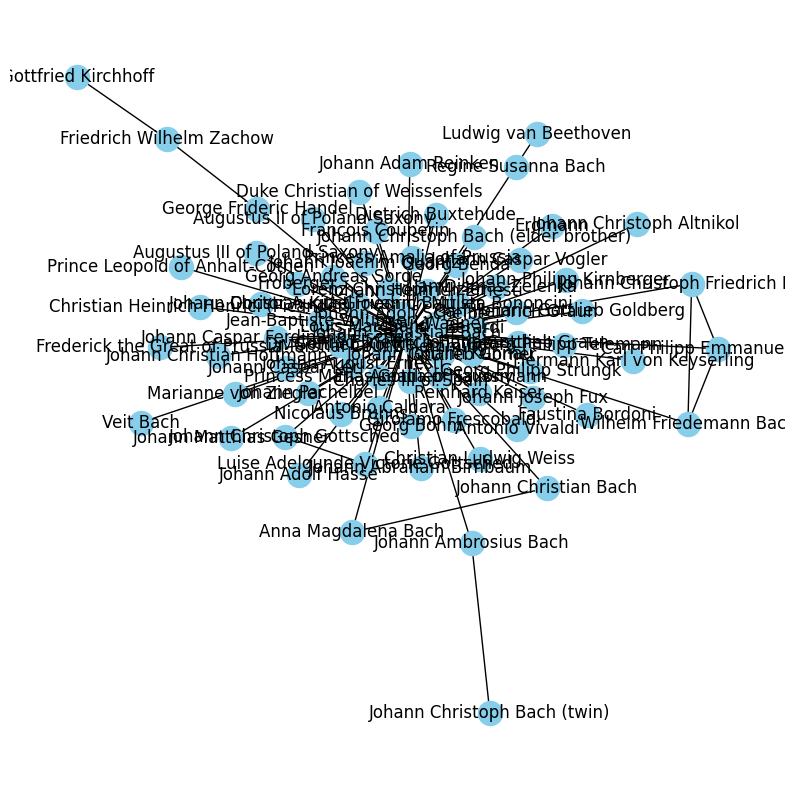

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, ax=ax, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## Drawing a graph with pyvis

<Axes: title={'center': 'Top 10 Degree Centrality Scores'}>

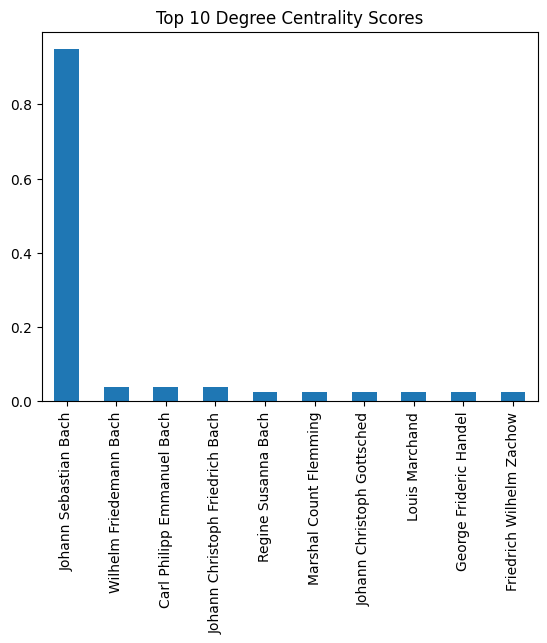

In [31]:
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar', title='Top 10 Degree Centrality Scores', legend=False)

<Axes: title={'center': 'Top 10 Betweenness Centrality Scores'}>

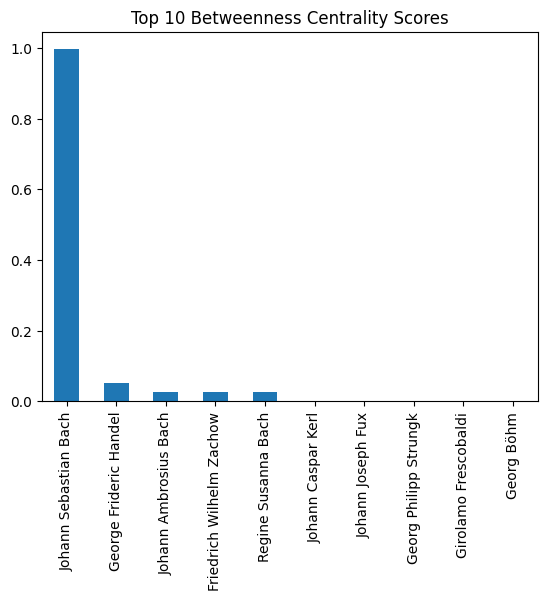

In [32]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar', title='Top 10 Betweenness Centrality Scores', legend=False)

<Axes: title={'center': 'Top 10 Closeness Centrality Scores'}>

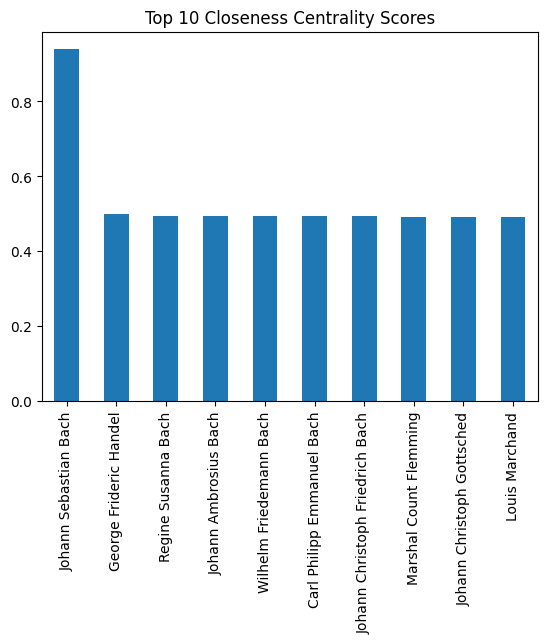

In [34]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar', title='Top 10 Closeness Centrality Scores', legend=False)